# DSC530 Data Exploration and Analysis 
## Week 12: Term Project : Do hospitals with higher readmission rates also have higher mortality rates?
This project’s code explores hospital readmission and mortality data to test the hypothesis: Do hospitals with higher readmission rates also have higher mortality rates? The analysis begins with data preparation and addressing any missing values. Then, exploratory data analysis (EDA) is conducted, including generating descriptive statistics, visualizations like histograms, and a cumulative distribution function (CDF) to understand the distribution of mortality and readmission scores. To test the hypothesis, a permutation test is applied to compare mortality scores between high and low readmission groups, chosen due to the non-normal data distribution. Additionally, a simple linear regression examines whether mortality scores predict readmission rates.  

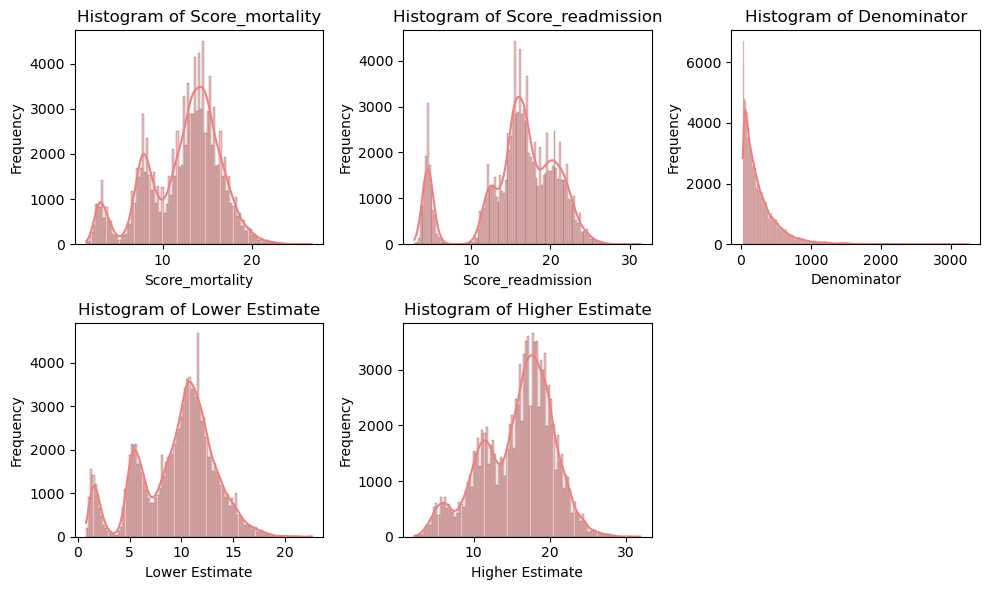


Score_mortality - Mean: 12.32888379786472, Std Dev: 4.1159593173652835
Number of outliers for Score_mortality: 25

Score_readmission - Mean: 15.874735743412382, Std Dev: 5.096920563507814
Number of outliers for Score_readmission: 5

Denominator - Mean: 265.3421669482455, Std Dev: 261.21930483424745
Number of outliers for Denominator: 2180

Lower Estimate - Mean: 9.595702015868662, Std Dev: 3.6244054175160763
Number of outliers for Lower Estimate: 46

Higher Estimate - Mean: 15.753474918843375, Std Dev: 4.626379986426984
Number of outliers for Higher Estimate: 30

Descriptive Statistics for Score_mortality:
Mean: 12.32888379786472
Median: 13.2
Mode: 14.4
Standard Deviation: 4.1159593173652835
Min: 1.4
Max: 26.8
Skewness: -0.5366134959996978
Tail Description: Left-skewed (negative skew) with a longer left tail.

Descriptive Statistics for Score_readmission:
Mean: 15.874735743412382
Median: 16.4
Mode: 15.5
Standard Deviation: 5.096920563507814
Min: 2.9
Max: 31.3
Skewness: -0.875858523186

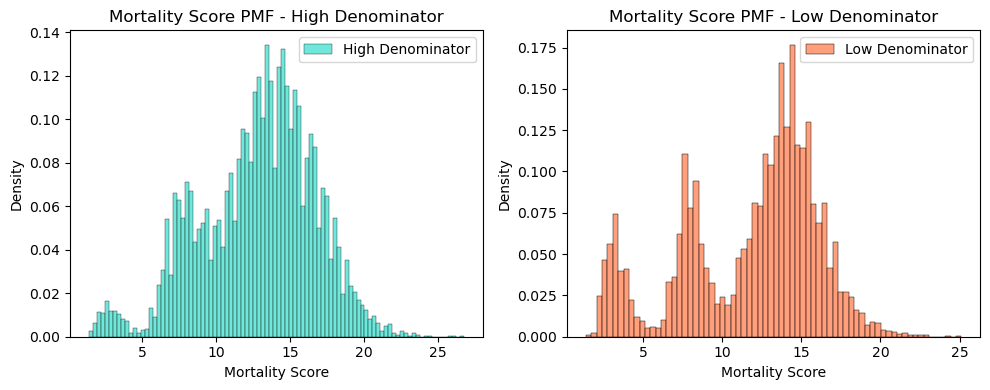

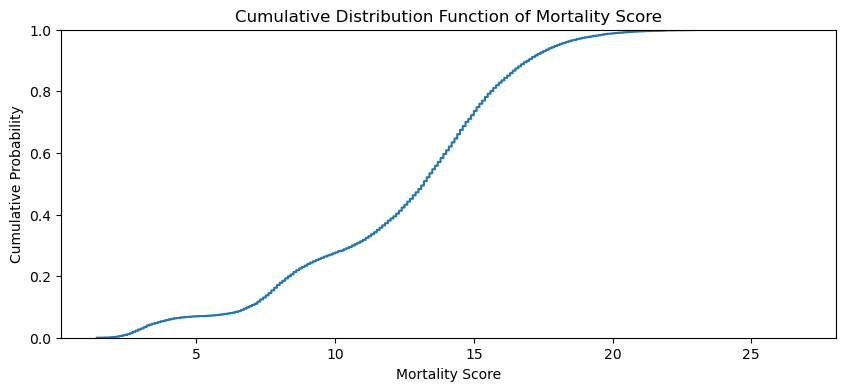

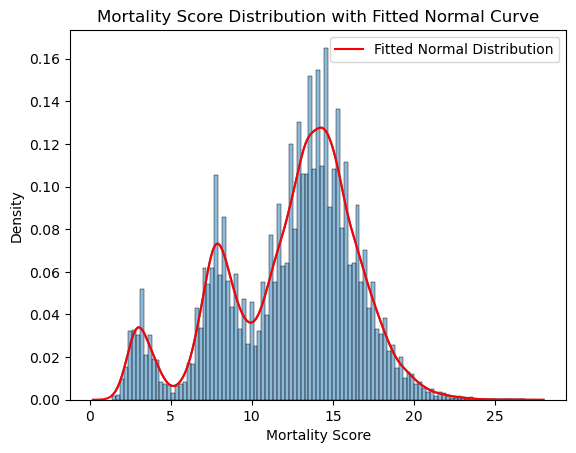


Correlation between Mortality and Readmission Scores: 0.004479555026011939
Correlation between Denominator and Mortality Score: 0.1361601086513735


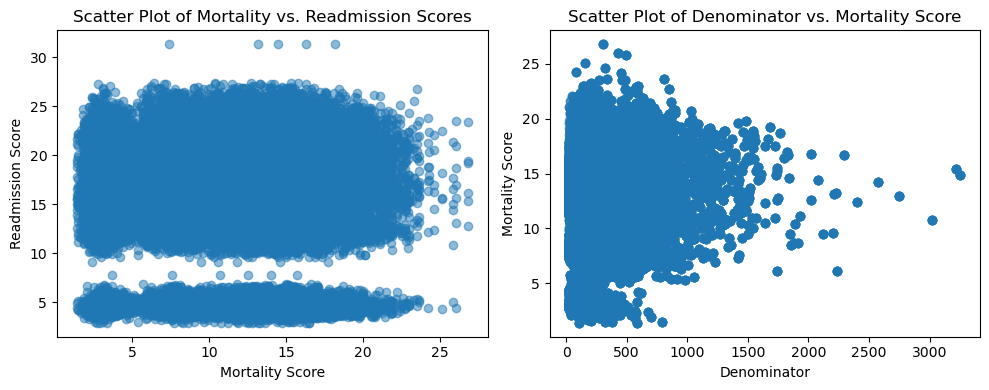

Observed difference in means: 0.036703755709734054
P-value from permutation test: 0.1296

Simple Linear Regression Results:
                            OLS Regression Results                            
Dep. Variable:      Score_readmission   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.269
Date:                Thu, 14 Nov 2024   Prob (F-statistic):              0.132
Time:                        21:39:23   Log-Likelihood:            -3.4454e+05
No. Observations:              113053   AIC:                         6.891e+05
Df Residuals:                  113051   BIC:                         6.891e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--

In [1]:
# Purpose: Analyze hospital readmission and mortality rates to examine if a relationship exists between high readmission rates and high mortality rates

#Import necessary libraries for data manipulation, visualization, and statistical analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For creating plots and visualizations
import seaborn as sns  # For advanced data visualizations
from scipy.stats import pearsonr  # For calculating Pearson correlation coefficient
import statsmodels.api as sm  # For conducting statistical modeling and regression analysis

# Load the CSV file
file_path = 'Readmissions_and_Deaths -Hospital.csv'   
data = pd.read_csv(file_path, parse_dates=['Measure Start Date', 'Measure End Date'])

# Data Cleaning and Preparation
# Convert numeric columns to numeric type and handle missing values
numeric_columns = ['Score', 'Denominator', 'Lower Estimate', 'Higher Estimate']
data[numeric_columns] = data[numeric_columns].replace('Not Available', np.nan).apply(pd.to_numeric, errors='coerce')

# Remove rows with missing values in selected columns
data = data.dropna(subset=numeric_columns + ['Measure Start Date', 'Measure End Date'])

# Calculate Duration in days
data['Duration'] = (data['Measure End Date'] - data['Measure Start Date']).dt.days

# Filter data for mortality and readmission records using 'Measure ID'
mortality_data = data[data['Measure ID'].str.startswith('MORT_30')]
readmission_data = data[data['Measure ID'].str.startswith('READM_30')]

# Merge mortality and readmission data on 'Provider ID' to create combined dataset
merged_data = pd.merge(mortality_data[['Provider ID', 'Score', 'Denominator', 'Lower Estimate', 'Higher Estimate']],
                       readmission_data[['Provider ID', 'Score']],
                       on='Provider ID',
                       suffixes=('_mortality', '_readmission'))

# Select key variables for analysis
variables = ['Score_mortality', 'Score_readmission', 'Denominator', 'Lower Estimate', 'Higher Estimate']

# Step 1: Histogram for Each of the 5 Variables and Outlier Analysis
plt.figure(figsize=(10, 6))  # Set figure size for better visualization

# Loop through the selected variables to create histograms
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # Create a subplot for each variable
    sns.histplot(merged_data[var], kde=True, color='lightcoral')  # Histogram with KDE in dark blue
    
    # Set the title and labels for each plot
    plt.title(f'Histogram of {var}', fontsize=12, color='black')  # Set title color to black
    plt.xlabel(var, fontsize=10, color='black')  # Set x-label color to black
    plt.ylabel('Frequency', fontsize=10, color='black')  # Set y-label color to black

    # Outlier Analysis: Calculate and mark outliers
    q1 = merged_data[var].quantile(0.25)  # First quartile
    q3 = merged_data[var].quantile(0.75)  # Third quartile
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr  # Lower bound for outliers
    upper_bound = q3 + 1.5 * iqr  # Upper bound for outliers
    
    # Identify outliers
    outliers = merged_data[(merged_data[var] < lower_bound) | (merged_data[var] > upper_bound)]
    
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the histograms

# Outlier analysis
for var in variables:
    mean = merged_data[var].mean()
    std_dev = merged_data[var].std()
    outliers = merged_data[(merged_data[var] < mean - 3 * std_dev) | (merged_data[var] > mean + 3 * std_dev)]
    print(f"\n{var} - Mean: {mean}, Std Dev: {std_dev}")
    print(f"Number of outliers for {var}: {len(outliers)}")

# Step 2: Descriptive Statistics
for var in variables:
    mean = merged_data[var].mean()
    median = merged_data[var].median()
    mode = merged_data[var].mode()[0]
    std_dev = merged_data[var].std()
    min_val = merged_data[var].min()
    max_val = merged_data[var].max()
    skewness = merged_data[var].skew()
    
    print(f"\nDescriptive Statistics for {var}:")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Skewness: {skewness}")
    
    # Additional information about skewness and tails
    if skewness > 0:
        tail_description = "Right-skewed (positive skew) with a longer right tail."
    elif skewness < 0:
        tail_description = "Left-skewed (negative skew) with a longer left tail."
    else:
        tail_description = "Symmetric distribution with no skewness."
    
    print(f"Tail Description: {tail_description}")

# Step 3: PMF Comparison for Mortality Score by Denominator
high_denominator = merged_data[merged_data['Denominator'] > merged_data['Denominator'].median()]
low_denominator = merged_data[merged_data['Denominator'] <= merged_data['Denominator'].median()]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(high_denominator['Score_mortality'], kde=False, stat='density', color='turquoise', label='High Denominator')
plt.title('Mortality Score PMF - High Denominator')
plt.xlabel('Mortality Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(low_denominator['Score_mortality'], kde=False, stat='density', color='coral', label='Low Denominator')
plt.title('Mortality Score PMF - Low Denominator')
plt.xlabel('Mortality Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: CDF for Mortality Score
plt.figure(figsize=(10, 4))
sns.ecdfplot(merged_data['Score_mortality'])
plt.title('Cumulative Distribution Function of Mortality Score')
plt.xlabel('Mortality Score')
plt.ylabel('Cumulative Probability')
plt.show()

# Step 5: Analytical Distribution (Normal Distribution Fitting)
sns.histplot(merged_data['Score_mortality'], kde=True, stat='density')
sns.kdeplot(merged_data['Score_mortality'], color='red', label='Fitted Normal Distribution')
plt.title('Mortality Score Distribution with Fitted Normal Curve')
plt.xlabel('Mortality Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Step 6: Scatter Plots and Correlation Analysis
# Scatter Plot 1: Mortality vs. Readmission Scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(merged_data['Score_mortality'], merged_data['Score_readmission'], alpha=0.5)
plt.xlabel('Mortality Score')
plt.ylabel('Readmission Score')
plt.title('Scatter Plot of Mortality vs. Readmission Scores')
correlation_1, _ = pearsonr(merged_data['Score_mortality'], merged_data['Score_readmission'])
print(f"\nCorrelation between Mortality and Readmission Scores: {correlation_1}")

# Scatter Plot 2: Denominator vs. Mortality Score
plt.subplot(1, 2, 2)
plt.scatter(merged_data['Denominator'], merged_data['Score_mortality'], alpha=0.5)
plt.xlabel('Denominator')
plt.ylabel('Mortality Score')
plt.title('Scatter Plot of Denominator vs. Mortality Score')
correlation_2, _ = pearsonr(merged_data['Denominator'], merged_data['Score_mortality'])
print(f"Correlation between Denominator and Mortality Score: {correlation_2}")
plt.tight_layout()
plt.show()

# Step 7: Hypothesis Test (Performed permutation test to evaluate the relationship between Score_mortality and Score_readmission variables)
# Create high and low readmission groups based on the median
median_readmission = merged_data['Score_readmission'].median()
high_readmission = merged_data[merged_data['Score_readmission'] > median_readmission]
low_readmission = merged_data[merged_data['Score_readmission'] <= median_readmission]

# Observed difference in means
observed_diff = high_readmission['Score_mortality'].mean() - low_readmission['Score_mortality'].mean()

# Combine both groups for permutation
combined_scores = np.concatenate([high_readmission['Score_mortality'].values, low_readmission['Score_mortality'].values])
n_high = high_readmission.shape[0]
n_low = low_readmission.shape[0]

# Number of permutations
n_permutations = 10000
permuted_diffs = []

# Permutation test
for _ in range(n_permutations):
    np.random.shuffle(combined_scores)
    new_high = combined_scores[:n_high]
    new_low = combined_scores[n_high:]
    permuted_diff = new_high.mean() - new_low.mean()
    permuted_diffs.append(permuted_diff)

# Calculate p-value
p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

# Output the results
print(f"Observed difference in means: {observed_diff}")
print(f"P-value from permutation test: {p_value}")


# Step 8: Regression Analysis (Mortality as Dependent, Readmission as Explanatory)
X = merged_data['Score_mortality']
y = merged_data['Score_readmission']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("\nSimple Linear Regression Results:")
print(model.summary())